In [2]:
!pip install pyarrow
!pip install fastparquet
!pip install s3fs
!pip install pandas
!pip install config
!pip install seaborn
!pip install scikit-learn
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 297.1 MB 8.1 kB/s              


In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from tqdm import tqdm
import boto3

# Dicionário de dados | Campos
- IdProvedorDados: Um código que indica o provedor TPEP que forneceu o registro.
    1= Creative Mobile Technologies, LLC; 
    2= VeriFone Inc.

- DataHoraOrigem: A data e hora em que o medidor foi acionado.

- DataHoraDestino: A data e hora em que o medidor foi desativado.

- ContagemPassageiros: O número de passageiros no veículo. Este é um valor inserido pelo driver.

- DistanciaViagemMilhas: A distância percorrida da viagem em milhas informada pelo taxímetro.

- IdZonaOrigem:  TLC Taxi Zone em que o taxímetro estava engajado

- IdZonaDestino TLC Taxi Zone em que o taxímetro foi desativado

- IdTaxa: Código da tarifa final em vigor no final da viagem.
    1= Standard rate
    2=JFK
    3=Newark
    4=Nassau or Westchester
    5=Negotiated fare
    6=Group ride

- IdIndicadorArmazVeiculo: Esta flag indica se o registro da viagem foi realizado no veículo memória antes de enviar ao fornecedor, também conhecido como “armazenar e encaminhar”, porque o veículo não tinha conexão com o servidor.
Y= store and forward trip
N= not a store and forward trip

- IdTipoPagamento: Um código numérico que significa como o passageiro pagou pela viagem.
    1= Credit card
    2= Cash
    3= No charge
    4= Dispute
    5= Unknown
    6= Voided trip

- TarifaTaximetro: A tarifa de tempo e distância calculada pelo taxímetro.

- Extra: Extras e sobretaxas diversos. Atualmente, isso inclui apenas os US$ 0,50 e US$ 1 na hora do rush e nas tarifas noturnas.

- TaxaMTA: imposto MTA de US$ 0,50 que é acionado automaticamente com base na medição taxa em uso.

- SobretaxaMelhoria: sobretaxa de melhoria de US$ 0,30 avaliada em viagens no momento da retirada da bandeira. A sobretaxa de melhoria começou a ser cobrada em 2015.

- ValorGorjeta: Valor da gorjeta – Este campo é preenchido automaticamente para cartão de crédito pontas. Gorjetas em dinheiro não estão incluídas.

- ValorPedagios: Valor total de todos os pedágios pagos na viagem.

- TotalPago: O valor total cobrado dos passageiros. Não inclui gorjetas em dinheiro

- SobretaxaCongestionamento: Valor total arrecadado em viagem pela sobretaxa de congestionamento do NYS.

- TaxaAeroporto: $ 1,25 para retirada somente nos aeroportos LaGuardia e John F. Kennedy

In [32]:
s3 = boto3.resource('s3')
bucketSourceName = 'taxis-ny-project-group-g'
folderSourceName = 'delivery/trip data'
bucketSource = s3.Bucket(bucketSourceName)
source_file = ''
df_total=pd.DataFrame()

for year in range(2022,2024):
    folderSourcePrefix = "{}/{}".format(folderSourceName,year)

    for obj in bucketSource.objects.filter(Prefix=folderSourcePrefix):
            source_filename = (obj.key).split('/')[2]
            target_filename = "s3a://{}/{}/{}".format(bucketSourceName, folderSourceName, source_filename)
            if(source_file != source_filename):
                source_file = source_filename
                #Leitura de arquivo
                df_data = pd.read_parquet(target_filename)
                df_total=pd.concat([df_total,df_data])


In [33]:
df_total

,IdProvedorDados,DataHoraOrigem,DataHoraDestino,ContagemPassageiros,DistanciaViagemMilhas,IdTaxa,IdIndicadorArmazVeiculo,IdZonaOrigem,IdZonaDestino,IdTipoPagamento,TarifaTaximetro,Extra,TaxaMTA,ValorGorjeta,ValorPedagios,SobretaxaMelhoria,TotalPago,SobretaxaCongestionamento,TaxaAeroporto
0,2,2022-01-06 16:16:43,2022-01-06 16:20:17,1,0.73,1,N,229,140,2,4.5,1.0,0.5,0.00,0.0,0.3,8.800000,2.5,0.00
1,2,2022-01-03 20:02:29,2022-01-03 20:16:02,1,2.57,1,N,186,141,1,11.0,0.5,0.5,2.96,0.0,0.3,17.760000,2.5,0.00
2,2,2022-01-21 19:52:54,2022-01-21 20:03:16,1,1.09,1,N,90,107,1,8.0,1.0,0.5,3.08,0.0,0.3,15.380000,2.5,0.00
3,2,2022-01-21 11:43:59,2022-01-21 11:46:28,3,0.46,1,N,142,143,1,4.0,0.0,0.5,1.82,0.0,0.3,9.120000,2.5,0.00
4,1,2022-01-31 17:38:42,2022-01-31 17:48:05,1,1.80,1,N,48,90,1,8.5,3.5,0.5,2.55,0.0,0.3,15.350000,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,2023-06-01 00:38:42,2023-06-01 00:52:25,2,5.62,1,N,132,130,1,24.0,1.0,0.5,4.00,0.0,1.0,32.250000,0.0,1.75
9996,2,2023-06-02 17:59:34,2023-06-02 18:07:01,1,1.33,1,N,261,211,1,9.3,2.5,0.5,3.16,0.0,1.0,18.959999,2.5,0.00
9997,2,2023-06-19 13:43:52,2023-06-19 13:55:23,1,1.94,1,N,229,236,1,12.8,0.0,0.5,2.52,0.0,1.0,19.320000,2.5,0.00
9998,2,2023-06-11 17:59:31,2023-06-11 18:01:57,2,0.32,1,N,142,142,1,4.4,0.0,0.5,1.68,0.0,1.0,10.080000,2.5,0.00


In [34]:
(df_total.isna().sum()/df_total.shape[0]*100).map("{:.2f}%".format)

IdProvedorDados              0.00%
DataHoraOrigem               0.00%
DataHoraDestino              0.00%
ContagemPassageiros          0.00%
DistanciaViagemMilhas        0.00%
IdTaxa                       0.00%
IdIndicadorArmazVeiculo      0.00%
IdZonaOrigem                 0.00%
IdZonaDestino                0.00%
IdTipoPagamento              0.00%
TarifaTaximetro              0.00%
Extra                        0.00%
TaxaMTA                      0.00%
ValorGorjeta                 0.00%
ValorPedagios                0.00%
SobretaxaMelhoria            0.00%
TotalPago                    0.00%
SobretaxaCongestionamento    0.00%
TaxaAeroporto                0.00%
dtype: object

In [35]:
cols_remove=['ContagemPassageiros','IdProvedorDados','IdIndicadorArmazVeiculo']

In [36]:
df_total = df_total.drop(columns=cols_remove)

df_total = df_total.dropna()

In [37]:
df_total.shape[0]

180000

In [38]:
df_total.isna().sum()/df_total.shape[0]

DataHoraOrigem               0.0
DataHoraDestino              0.0
DistanciaViagemMilhas        0.0
IdTaxa                       0.0
IdZonaOrigem                 0.0
IdZonaDestino                0.0
IdTipoPagamento              0.0
TarifaTaximetro              0.0
Extra                        0.0
TaxaMTA                      0.0
ValorGorjeta                 0.0
ValorPedagios                0.0
SobretaxaMelhoria            0.0
TotalPago                    0.0
SobretaxaCongestionamento    0.0
TaxaAeroporto                0.0
dtype: float64

In [40]:
df_total.columns

Index(['DataHoraOrigem', 'DataHoraDestino', 'DistanciaViagemMilhas', 'IdTaxa',
       'IdZonaOrigem', 'IdZonaDestino', 'IdTipoPagamento', 'TarifaTaximetro',
       'Extra', 'TaxaMTA', 'ValorGorjeta', 'ValorPedagios',
       'SobretaxaMelhoria', 'TotalPago', 'SobretaxaCongestionamento',
       'TaxaAeroporto'],
      dtype='object')

In [42]:
df_total.sample(5)

,DataHoraOrigem,DataHoraDestino,DistanciaViagemMilhas,IdTaxa,IdZonaOrigem,IdZonaDestino,IdTipoPagamento,TarifaTaximetro,Extra,TaxaMTA,ValorGorjeta,ValorPedagios,SobretaxaMelhoria,TotalPago,SobretaxaCongestionamento,TaxaAeroporto
9769,2023-05-04 19:45:07,2023-05-04 19:56:38,0.92,1,233,230,1,10.700000,2.5,0.5,3.44,0.0,1.0,20.639999,2.5,0.0
7306,2022-04-21 17:34:03,2022-04-21 17:48:47,0.90,1,230,50,1,10.000000,3.5,0.5,2.15,0.0,0.3,16.450001,2.5,0.0
1022,2023-04-29 08:33:36,2023-04-29 08:47:53,3.28,1,239,162,1,17.700001,0.0,0.5,1.08,0.0,1.0,22.780001,2.5,0.0
8103,2023-01-22 12:46:23,2023-01-22 12:56:16,1.54,1,114,90,1,11.400000,0.0,0.5,3.08,0.0,1.0,18.480000,2.5,0.0
7145,2022-01-06 18:12:47,2022-01-06 18:25:10,0.61,1,163,48,2,8.500000,1.0,0.5,0.00,0.0,0.3,12.800000,2.5,0.0


In [43]:
df_total.head()

,DataHoraOrigem,DataHoraDestino,DistanciaViagemMilhas,IdTaxa,IdZonaOrigem,IdZonaDestino,IdTipoPagamento,TarifaTaximetro,Extra,TaxaMTA,ValorGorjeta,ValorPedagios,SobretaxaMelhoria,TotalPago,SobretaxaCongestionamento,TaxaAeroporto
0,2022-01-06 16:16:43,2022-01-06 16:20:17,0.73,1,229,140,2,4.5,1.0,0.5,0.00,0.0,0.3,8.80,2.5,0.0
1,2022-01-03 20:02:29,2022-01-03 20:16:02,2.57,1,186,141,1,11.0,0.5,0.5,2.96,0.0,0.3,17.76,2.5,0.0
2,2022-01-21 19:52:54,2022-01-21 20:03:16,1.09,1,90,107,1,8.0,1.0,0.5,3.08,0.0,0.3,15.38,2.5,0.0
3,2022-01-21 11:43:59,2022-01-21 11:46:28,0.46,1,142,143,1,4.0,0.0,0.5,1.82,0.0,0.3,9.12,2.5,0.0
4,2022-01-31 17:38:42,2022-01-31 17:48:05,1.80,1,48,90,1,8.5,3.5,0.5,2.55,0.0,0.3,15.35,2.5,0.0


In [44]:
diff = df_total['DataHoraDestino'] - df_total['DataHoraOrigem']
diff = diff.reset_index(drop=True)
diff

0        0 days 00:03:34
1        0 days 00:13:33
2        0 days 00:10:22
3        0 days 00:02:29
4        0 days 00:09:23
               ...      
179995   0 days 00:13:43
179996   0 days 00:07:27
179997   0 days 00:11:31
179998   0 days 00:02:26
179999   0 days 00:10:40
Length: 180000, dtype: timedelta64[us]

In [45]:
corrida=[]
for tempo in diff:
   corrida.append( tempo.total_seconds() / 60)
#Criando feature de duração da corrida em minutos
df_total['TempoCorrida']=corrida
#Criando feature de dia da semana
df_total['DiaCorrida'] = df_total['DataHoraDestino'].dt.dayofweek

> Tabela dias 

- 0 = Segunda
- 1 = Terça
- 2 = Quarta
- 3 = Quinta
- 4 = Sexta
- 5 = Sabado
- 6 = domingo

In [46]:
df_total['DiaCorrida'].value_counts()

DiaCorrida
3    27849
4    27445
2    27018
5    26257
1    26118
0    22904
6    22409
Name: count, dtype: int64

In [48]:
df_total['OutrasTaxas']= df_total['Extra'] + df_total['TaxaMTA'] + df_total['ValorGorjeta'] + df_total['ValorPedagios'] + df_total['SobretaxaMelhoria'] + df_total['SobretaxaCongestionamento'] + df_total['TaxaAeroporto']

In [49]:
df_clean = df_total.drop(columns=['DataHoraOrigem','DataHoraDestino','Extra','TaxaMTA','ValorGorjeta','ValorPedagios','SobretaxaMelhoria','SobretaxaCongestionamento','TaxaAeroporto'])

In [50]:
df_clean

,DistanciaViagemMilhas,IdTaxa,IdZonaOrigem,IdZonaDestino,IdTipoPagamento,TarifaTaximetro,TotalPago,TempoCorrida,DiaCorrida,OutrasTaxas
0,0.73,1,229,140,2,4.5,8.800000,3.566667,3,4.30
1,2.57,1,186,141,1,11.0,17.760000,13.550000,0,6.76
2,1.09,1,90,107,1,8.0,15.380000,10.366667,4,7.38
3,0.46,1,142,143,1,4.0,9.120000,2.483333,4,5.12
4,1.80,1,48,90,1,8.5,15.350000,9.383333,0,9.35
...,...,...,...,...,...,...,...,...,...,...
9995,5.62,1,132,130,1,24.0,32.250000,13.716667,3,8.25
9996,1.33,1,261,211,1,9.3,18.959999,7.450000,4,9.66
9997,1.94,1,229,236,1,12.8,19.320000,11.516667,0,6.52
9998,0.32,1,142,142,1,4.4,10.080000,2.433333,6,5.68


In [51]:
df_clean['TotalPago'].value_counts()

TotalPago
11.800000     1948
13.300000     1899
10.800000     1891
9.800000      1887
16.799999     1883
              ... 
84.870003        1
72.239998        1
89.129997        1
179.649994       1
12.290000        1
Name: count, Length: 6117, dtype: int64

In [52]:
df_clean.describe()

,DistanciaViagemMilhas,IdTaxa,IdZonaOrigem,IdZonaDestino,IdTipoPagamento,TarifaTaximetro,TotalPago,TempoCorrida,DiaCorrida,OutrasTaxas
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,1.800000e+05,180000.000000,180000.000000
mean,3.511011,1.477006,165.191472,163.225872,1.228900,16.027905,23.502138,7.418676e+01,2.995667,8.138961
std,23.230042,6.253902,64.744312,70.033712,0.485118,15.887099,19.907211,2.432902e+04,1.931868,5.504574
min,0.000000,1.000000,1.000000,1.000000,1.000000,-576.000000,-617.849976,-5.053333e+01,0.000000,-41.849998
25%,1.100000,1.000000,132.000000,113.000000,1.000000,7.500000,12.960000,7.316667e+00,1.000000,5.360000
50%,1.820000,1.000000,162.000000,162.000000,1.000000,11.000000,17.280001,1.205000e+01,3.000000,6.940000
75%,3.440000,1.000000,234.000000,234.000000,1.000000,17.700001,25.299999,1.966667e+01,5.000000,9.150000
max,9674.059570,99.000000,265.000000,265.000000,4.000000,600.000000,601.000000,1.032193e+07,6.000000,185.800003


# removendo TotalPago, TarifaTaximetro e tempo de corrida negativos

In [53]:
df_clean = df_clean.loc[(df_clean['TotalPago'] > 0) & (df_clean['TarifaTaximetro'] > 0) & (df_clean['TempoCorrida'] > 0)]
df_clean.shape

(178506, 10)

In [54]:
df_clean.describe(percentiles=[.5,.6,.7,.8,.9,.95])

,DistanciaViagemMilhas,IdTaxa,IdZonaOrigem,IdZonaDestino,IdTipoPagamento,TarifaTaximetro,TotalPago,TempoCorrida,DiaCorrida,OutrasTaxas
count,178506.000000,178506.000000,178506.000000,178506.000000,178506.000000,178506.000000,178506.000000,1.785060e+05,178506.000000,178506.000000
mean,3.518734,1.476808,165.195937,163.197556,1.212172,16.283533,23.849142,7.471878e+01,2.994577,8.235067
std,23.321960,6.266690,64.735082,70.015488,0.443498,15.520240,19.447309,2.443062e+04,1.931624,5.406584
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.010000,0.310000,1.666667e-02,0.000000,0.000000
50%,1.830000,1.000000,162.000000,162.000000,1.000000,11.000000,17.299999,1.208333e+01,3.000000,6.960000
60%,2.280000,1.000000,170.000000,181.000000,1.000000,13.000000,19.700001,1.453333e+01,4.000000,7.800000
70%,2.920000,1.000000,230.000000,230.000000,1.000000,16.000000,23.100000,1.766667e+01,4.000000,8.700000
80%,4.230000,1.000000,236.000000,236.000000,2.000000,20.500000,28.799999,2.220000e+01,5.000000,9.850000
90%,8.960000,1.000000,239.000000,239.000000,2.000000,34.200001,47.099998,3.076667e+01,6.000000,12.700000
95%,15.270000,2.000000,261.000000,261.000000,2.000000,52.000000,69.360001,4.115000e+01,6.000000,19.849998


In [55]:
# Função para remover outliers usando o intervalo interquartil (IQR)
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[((df >= (Q1 - 1.5 * IQR)) & (df <= (Q3 + 1.5 * IQR))).all(axis=1)] ,Q1,Q3,IQR



In [57]:
# Remover outliers do DataFrame
df_sem_outliers ,Q1,Q3,IQR = remove_outliers(df_clean[['DistanciaViagemMilhas', 'TarifaTaximetro', 'TotalPago','TempoCorrida', 'OutrasTaxas']])
df_sem_outliers.reset_index(drop=True,inplace=True)
df_sem_outliers = df_sem_outliers.merge(df_clean[['IdTaxa','DiaCorrida']], left_index=True, right_index=True)

In [58]:
print('Valores Q1')
display(Q1)
print('---------------------------')
print('Valores Q3')
display(Q3)
print('---------------------------')
print('Valores IQR')
display(IQR)

Valores Q1


DistanciaViagemMilhas     1.100000
TarifaTaximetro           7.500000
TotalPago                12.980000
TempoCorrida              7.366667
OutrasTaxas               5.440000
Name: 0.25, dtype: float64

---------------------------
Valores Q3


DistanciaViagemMilhas     3.450000
TarifaTaximetro          18.000000
TotalPago                25.379999
TempoCorrida             19.700000
OutrasTaxas               9.160001
Name: 0.75, dtype: float64

---------------------------
Valores IQR


DistanciaViagemMilhas     2.350000
TarifaTaximetro          10.500000
TotalPago                12.400000
TempoCorrida             12.333333
OutrasTaxas               3.720001
dtype: float64

In [60]:
df_sem_outliers.describe(percentiles=[.5,.6,.7,.8,.9,.95])

,DistanciaViagemMilhas,TarifaTaximetro,TotalPago,TempoCorrida,OutrasTaxas,IdTaxa,DiaCorrida
count,178506.000000,178506.000000,178506.000000,178506.000000,178506.000000,178506.000000,178506.000000
mean,1.940046,9.433211,14.878557,10.644931,6.202650,1.476808,2.994577
std,1.321700,4.398400,5.183104,6.175067,2.033931,6.266690,1.931624
min,0.000000,2.500000,3.300000,0.033333,0.300000,1.000000,0.000000
50%,1.600000,8.500000,13.800000,9.383333,6.090000,1.000000,3.000000
60%,1.900000,9.500000,15.180000,10.966667,6.560000,1.000000,4.000000
70%,2.270000,11.000000,16.559999,12.866667,7.250000,1.000000,4.000000
80%,2.810000,12.500000,18.799999,15.283333,7.950000,1.000000,5.000000
90%,3.820000,16.000000,22.250000,19.216667,8.850000,1.000000,6.000000
95%,4.800000,18.500000,25.379999,22.583333,9.560000,2.000000,6.000000


# Correlações

In [62]:
df_sem_outliers.corr()

,DistanciaViagemMilhas,TarifaTaximetro,TotalPago,TempoCorrida,OutrasTaxas,IdTaxa,DiaCorrida
DistanciaViagemMilhas,1.000000,0.909035,0.884411,0.779127,0.275813,-0.000241,0.000931
TarifaTaximetro,0.909035,1.000000,0.955131,0.918153,0.262966,0.000769,0.002291
TotalPago,0.884411,0.955131,1.000000,0.884946,0.483118,0.000385,0.001055
TempoCorrida,0.779127,0.918153,0.884946,1.000000,0.275475,0.002009,0.002552
OutrasTaxas,0.275813,0.262966,0.483118,0.275475,1.000000,-0.000903,-0.000696
IdTaxa,-0.000241,0.000769,0.000385,0.002009,-0.000903,1.000000,-0.013245
DiaCorrida,0.000931,0.002291,0.001055,0.002552,-0.000696,-0.013245,1.000000


# Graficos Boxplot

In [64]:
#Gerando df_sample
df_sample = df_sem_outliers.reset_index(drop=True)

**Dia Semana X Distância Viagem**

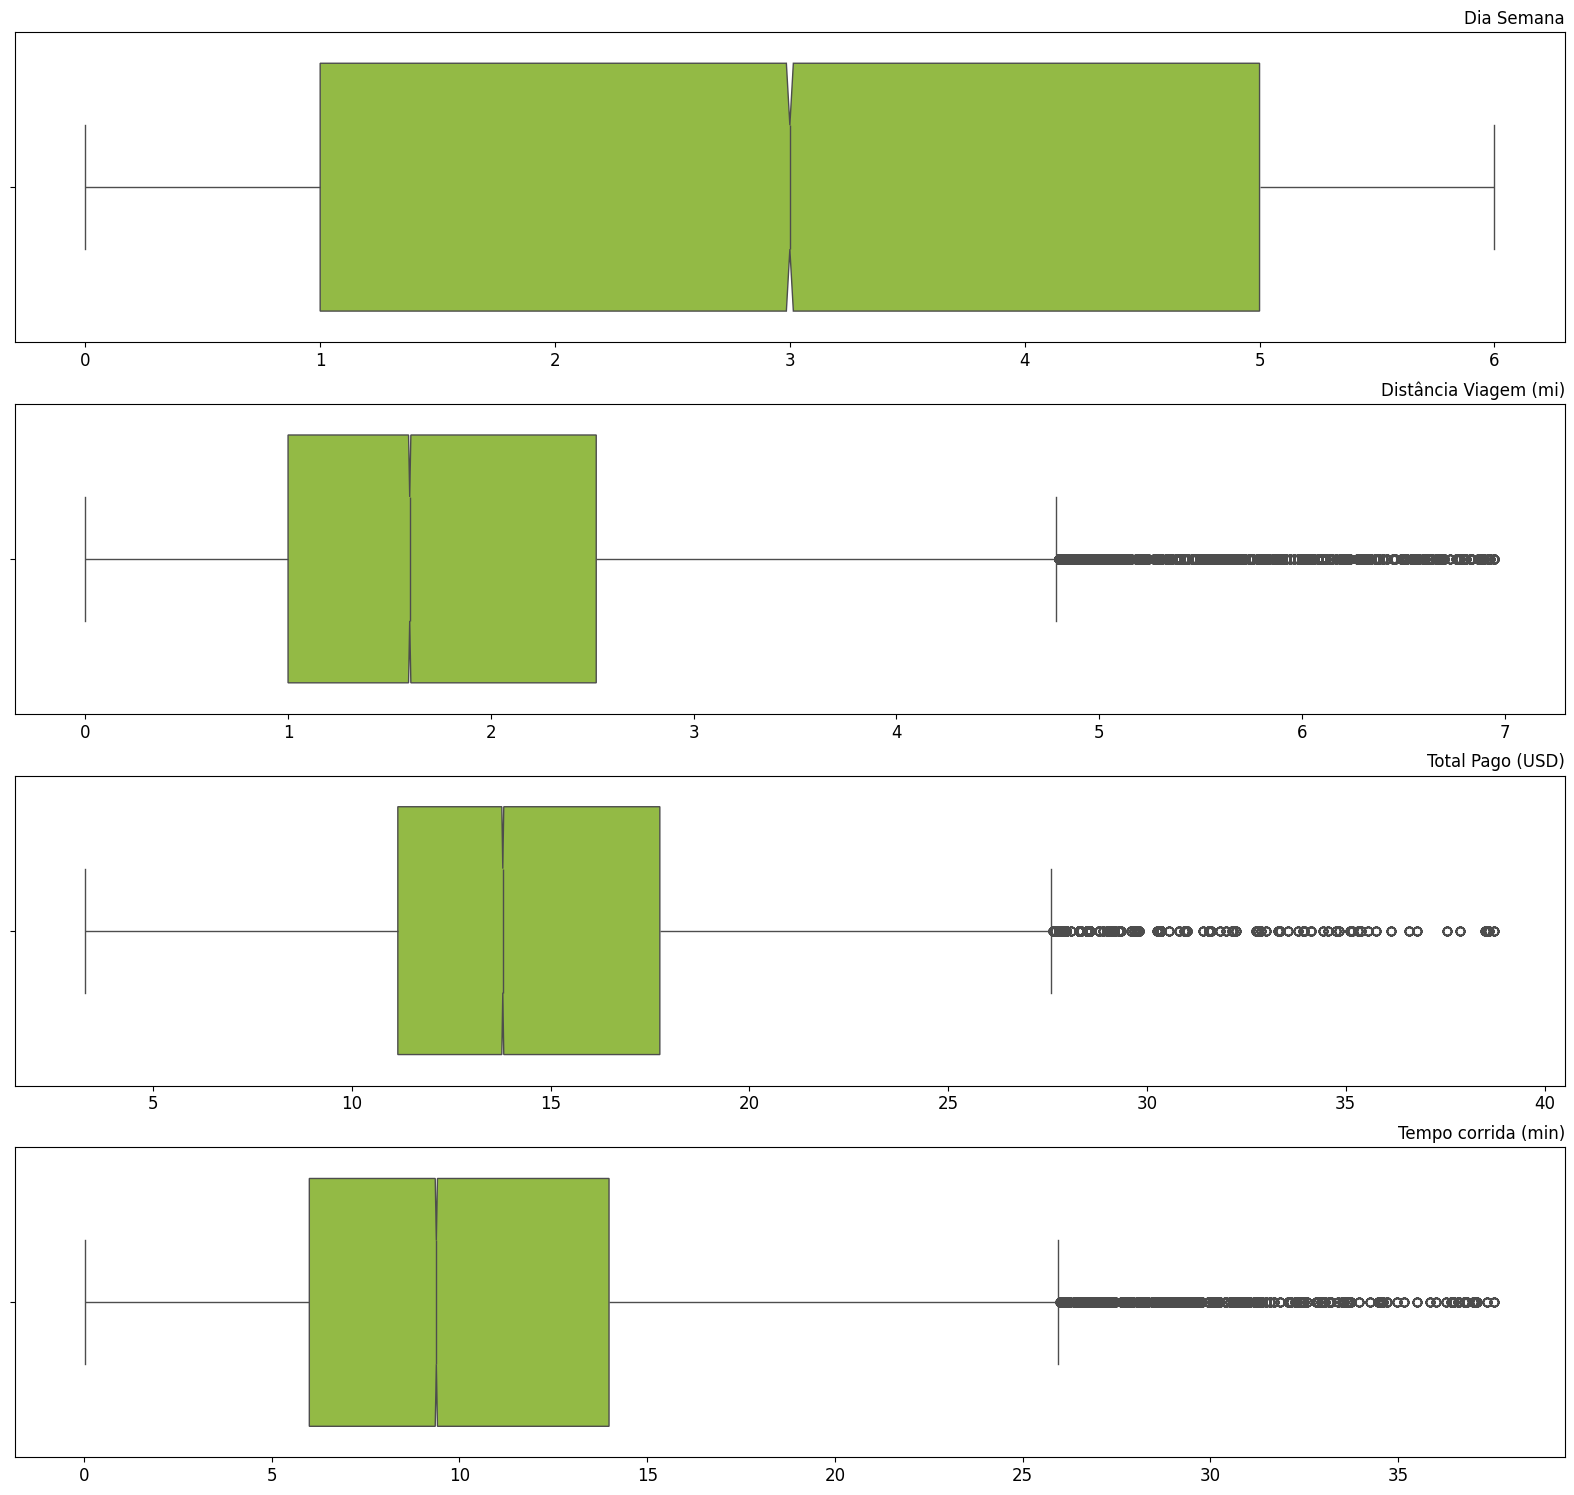

In [65]:
def graf_boxplot(param1, param2, param3, param4='yellowgreen'):
    sns.boxplot(data=param1, ax=param3, color=param4, notch=True, orient='h')
    param3.set(xlabel='', ylabel='')
    param3.tick_params(labelsize=12)
    param3.ticklabel_format(style='plain', axis='x')
    param3.set_title(param2, loc='right', fontsize=12)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(20, 15))

graf_boxplot(df_sample['DiaCorrida'], 'Dia Semana', ax1)
graf_boxplot(df_sample['DistanciaViagemMilhas'], 'Distância Viagem (mi)', ax2)
graf_boxplot(df_sample['TotalPago'], 'Total Pago (USD)', ax3)
graf_boxplot(df_sample['TempoCorrida'], 'Tempo corrida (min)', ax4)

plt.subplots_adjust(top=1.9, bottom=0.95)
plt.show()

In [ ]:
# Histogramas

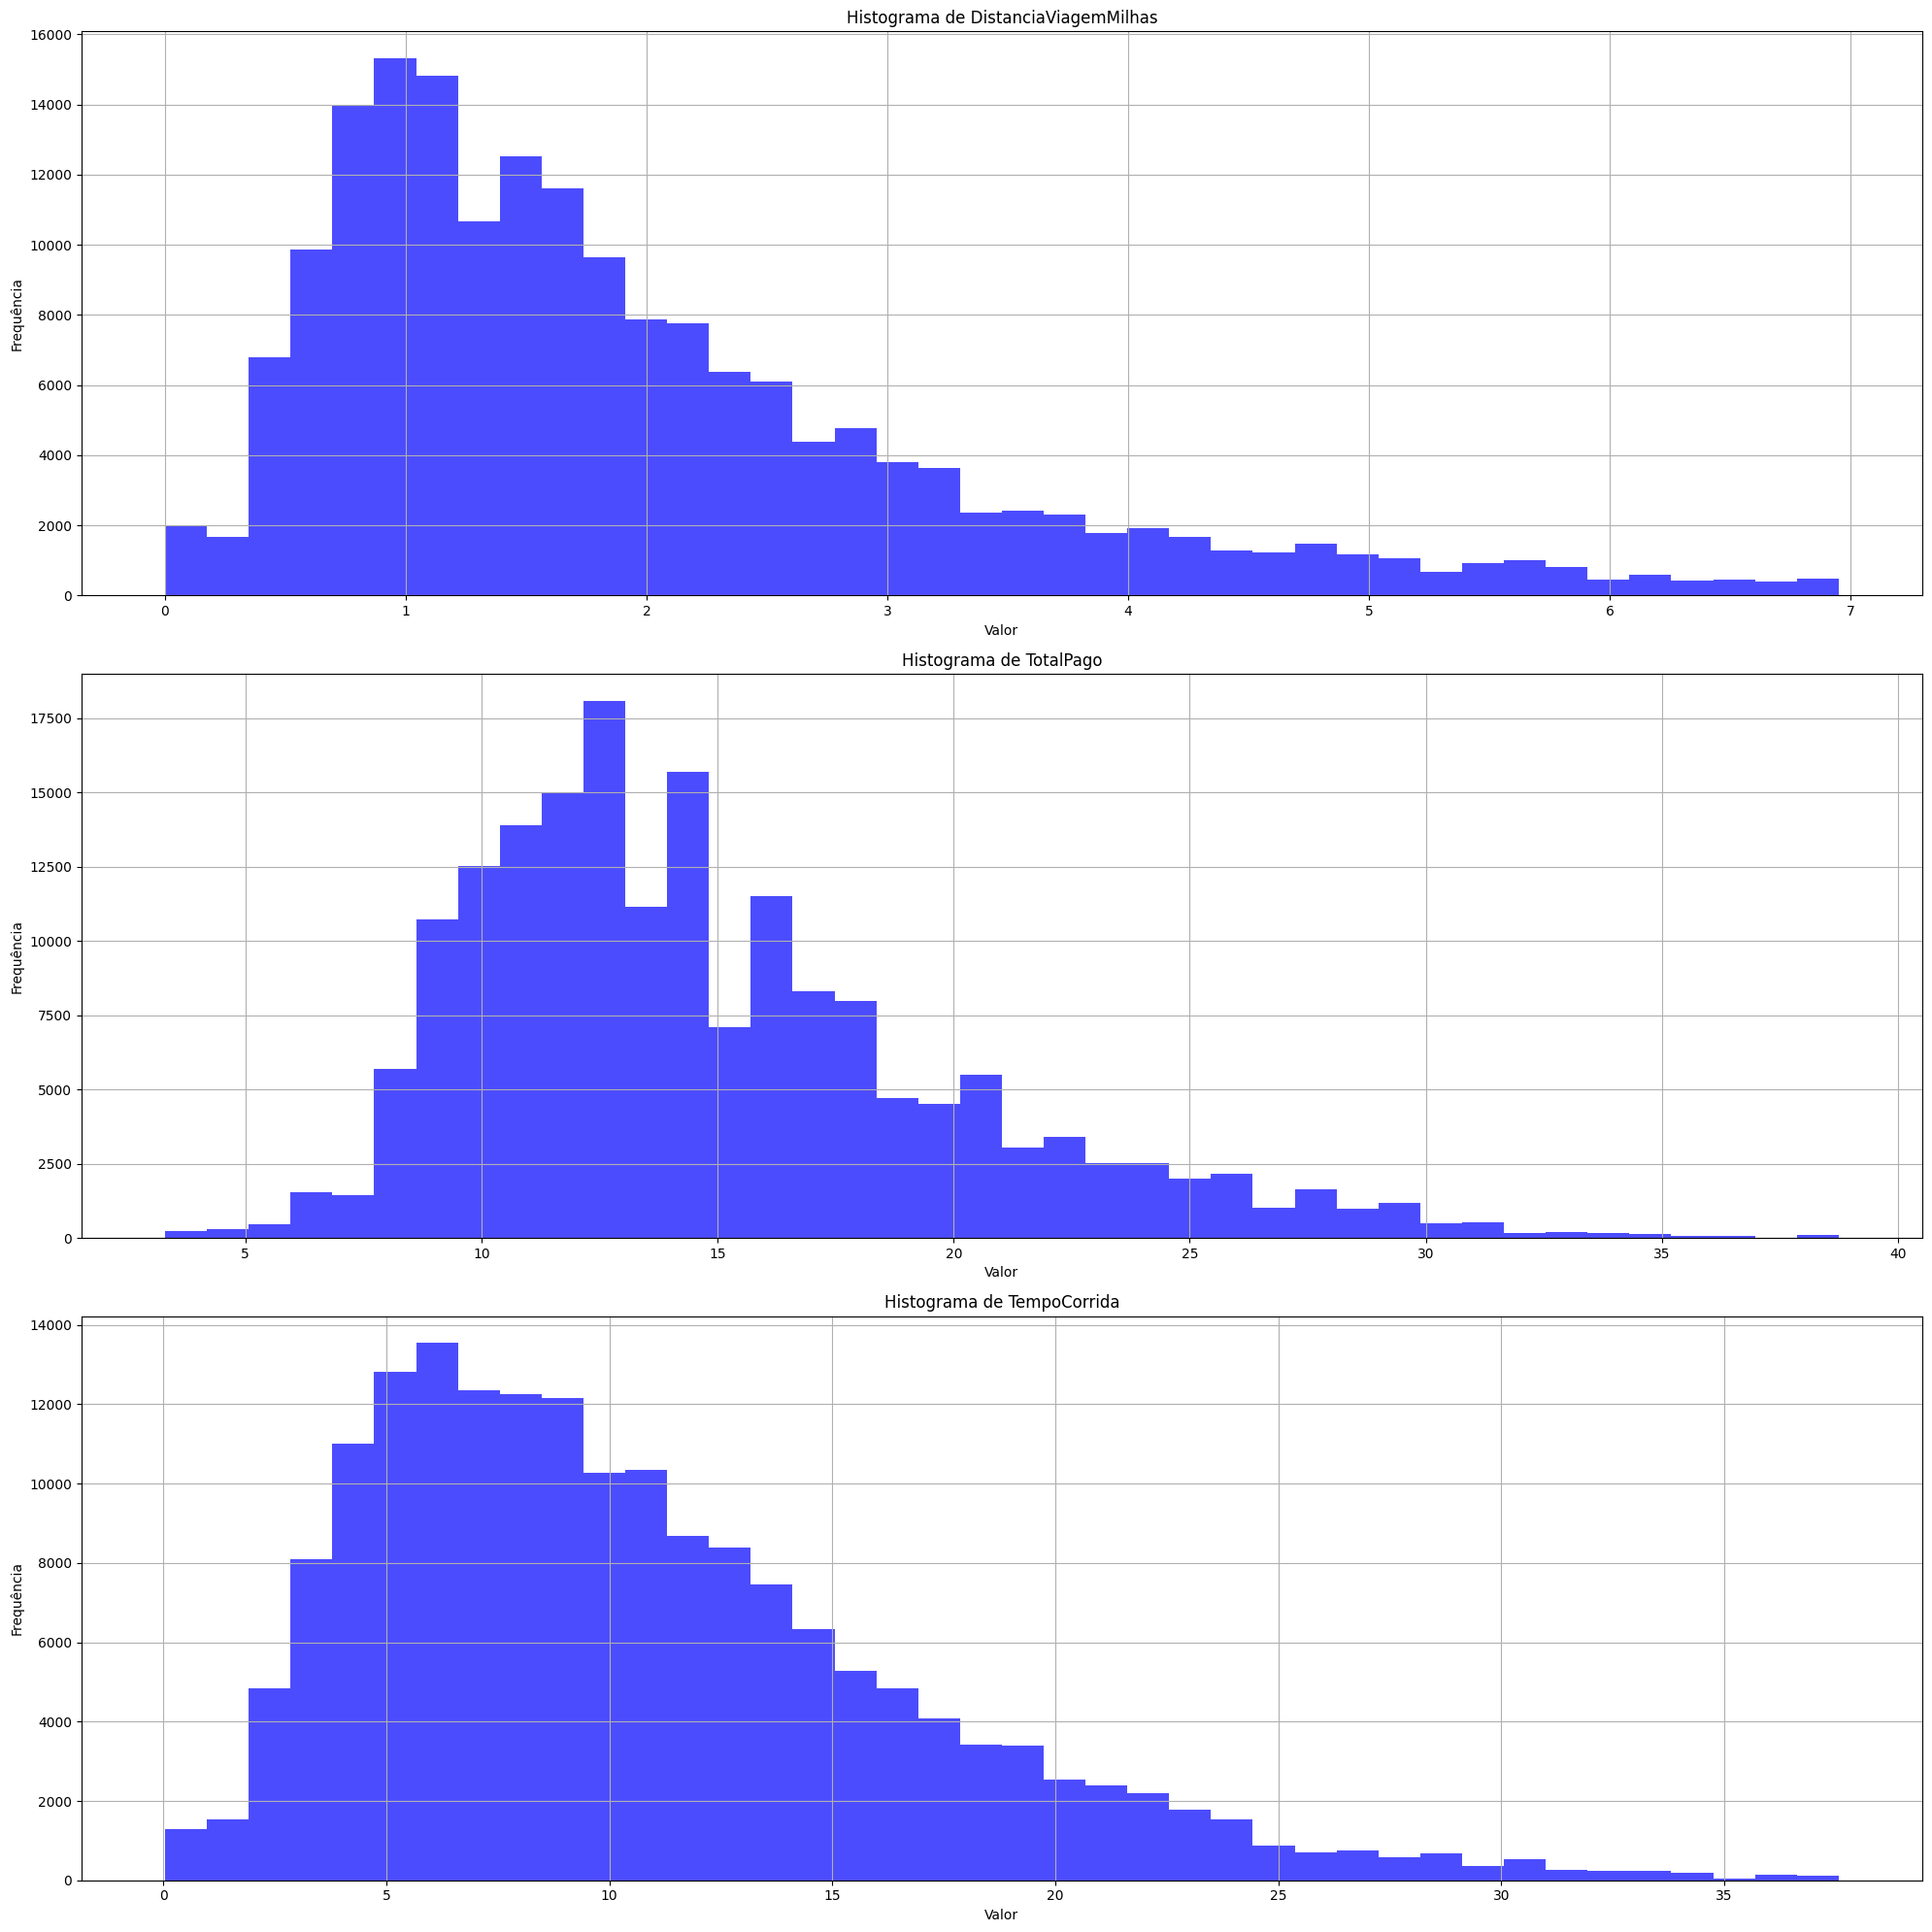

In [66]:
def plot_histogram(data, column_name, ax):
    # Plotando o histograma
    ax.hist(data[column_name], bins=40, color='blue', alpha=0.7)
    ax.set_title('Histograma de ' + column_name)
    ax.set_xlabel('Valor')
    ax.set_ylabel('Frequência')
    ax.grid(True)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

plot_histogram(df_sample, 'DistanciaViagemMilhas', ax1)
plot_histogram(df_sample, 'TotalPago', ax2)
plot_histogram(df_sample, 'TempoCorrida', ax3)

plt.tight_layout()
plt.show()

# Modelagem

In [67]:
X= df_sample.drop(["TotalPago"],axis =1)
y= df_sample["TotalPago"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=13)

- Como dados não tem distribuição normal é utilizado pipeline com StandardScaler antes de aplicar modelo de predição

In [68]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr=Pipeline([("scalar1",StandardScaler()),
                     ("lr_classifier",LinearRegression())])

pipeline_dt=Pipeline([("scalar2",StandardScaler()),
                     ("dt_classifier",DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf_classifier",RandomForestRegressor())])


pipeline_kn=Pipeline([("scalar4",StandardScaler()),
                     ("rf_classifier",KNeighborsRegressor())])


pipeline_xgb=Pipeline([("scalar5",StandardScaler()),
                     ("rf_classifier",XGBRegressor())])

# List of all the pipelines
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb]

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "LinearRegression", 1: "DecisionTree", 2: "RandomForest",3: "KNeighbors", 4: "XGBRegressor"}

# Fit the pipelines
for pipe in tqdm(pipelines):
    pipe.fit(X_train, y_train)

100%|██████████| 5/5 [00:15<00:00,  3.18s/it]


In [69]:
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train,scoring="neg_root_mean_squared_error", cv=5)
    cv_results_rms.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

LinearRegression: -0.893511 
DecisionTree: -0.009815 
RandomForest: -0.012333 
KNeighbors: -0.644645 
XGBRegressor: -0.262095 


In [70]:
# Model prediction on test data
pred = pipeline_xgb.predict(X_test)

In [71]:
# Model Evaluation
print("R^2:",metrics.r2_score(y_test, pred))
print("Adjusted R^2:",1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print("MAE:",metrics.mean_absolute_error(y_test, pred))
print("MSE:",metrics.mean_squared_error(y_test, pred))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, pred)))

R^2: 0.9975335422424084
Adjusted R^2: 0.9975332909903448
MAE: 0.14060897
MSE: 0.06652137
RMSE: 0.25791737
